**Глава 6. Кластеризация изображений**

Навигация к соседним тетрадям:
<!--NAVIGATION-->
<[Глава 5. Многовидовая геометрия](5_multiple_view_geometry.ipynb) | [Содержание](0_index.ipynb) | [Глава 7. Поиск изображений](7_searching_images.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/6_clustering_images.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>

In [1]:
import numpy as np
from scipy.cluster.vq import kmeans, vq, whiten
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw

In [2]:
try:
    import google.colab, sys
    !git clone https://github.com/mualal/computer-vision-with-python.git
    sys.path.append('computer-vision-with-python')
    %cd computer-vision-with-python
except:
    import sys
    sys.path.append('..')

In [3]:
import imtools
import pca
import hcluster

# Кластеризация методом K-средних
## Пакет кластеризации в SciPy

In [4]:
class0 = 1.5 * np.random.randn(100, 2)
class1 = np.random.randn(100, 2) + np.array([5, 5])
features = np.vstack((class0, class1))

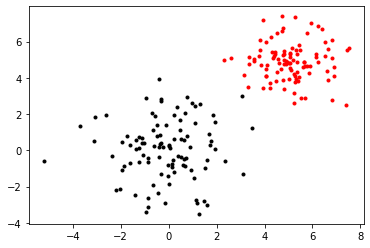

In [5]:
plt.figure()
plt.plot(class0[:,0], class0[:,1], 'k.')
plt.plot(class1[:,0], class1[:,1], 'r.')
plt.show()

In [6]:
centroids, variance = kmeans(features, 2)

In [7]:
code, distance = vq(features, centroids)

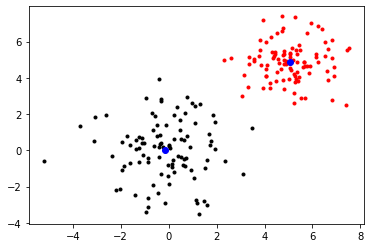

In [8]:
plt.figure()
ndx = np.where(code==0)[0]
plt.plot(features[ndx, 0], features[ndx, 1], 'k.')
ndx = np.where(code==1)[0]
plt.plot(features[ndx, 0], features[ndx, 1], 'r.')
plt.plot(centroids[:, 0], centroids[:, 1], 'bo')
plt.show()

## Кластеризация изображений

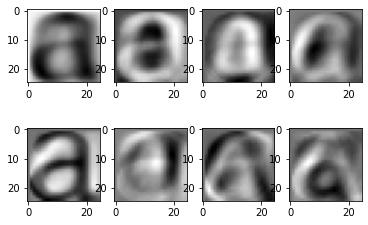

In [9]:
# вычисление некого среднего изображения и главных компонент набора изображений буквы "а" разными шрифтами
imlist = imtools.get_imlist(os.path.join('images_input', 'a_fonts'))

im_example = np.array(Image.open(imlist[0]))
m, n = im_example.shape[0:2]

immatrix = np.array([np.array(Image.open(im)).flatten() for im in imlist], 'f')
v, s, immean = pca.pca(immatrix)

plt.figure()
plt.gray()
plt.subplot(2, 4, 1)
plt.imshow(immean.reshape((m, n)))
for i in range(7):
    plt.subplot(2, 4, i+2)
    plt.imshow(v[i].reshape((m, n)))

In [10]:
imlist = imtools.get_imlist(os.path.join('images_input', 'a_fonts_for_clustering'))

immatrix = np.array([np.array(Image.open(im)).flatten() for im in imlist], 'f')

immean = immean.flatten()
projected = np.array([np.dot(v[:40], immatrix[i] - immean) for i, _ in enumerate(imlist)])

projected = whiten(projected)
centroids, distortion = kmeans(projected, 4)

code, distance = vq(projected, centroids)

Кластер №1


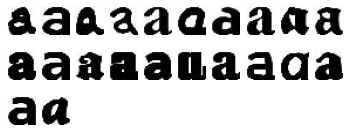

Кластер №2


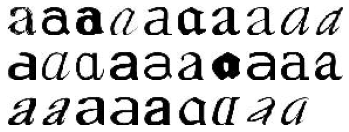

Кластер №3


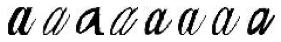

Кластер №4


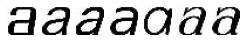

In [11]:
# нанесём кластеры на график
for k in range(4):
    ind = np.where(code == k)[0]
    print(f'Кластер №{k+1}')
    plt.figure()
    plt.gray()
    for i in range(np.minimum(len(ind), 50)):
        plt.subplot(5, 10, i+1)
        plt.imshow(immatrix[ind[i]].reshape((m, n)))
        plt.axis('off')
    plt.show()

## Визуализация проекций изображений на главные компоненты

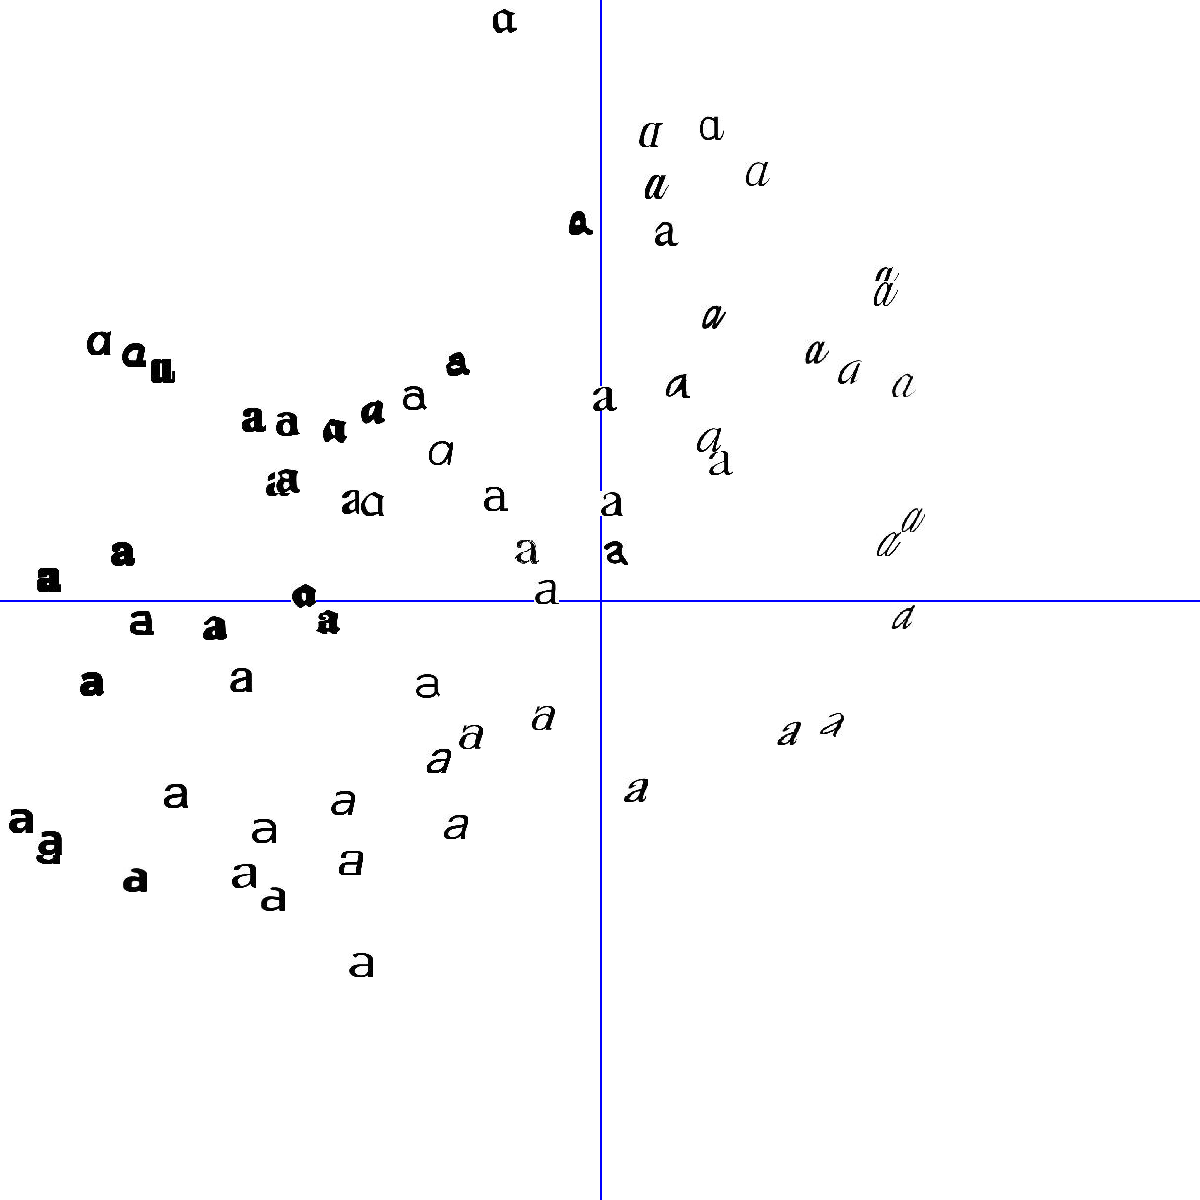

In [12]:
projected = np.array([np.dot(v[[0, 2]], immatrix[i] - immean) for i, _ in enumerate(imlist)])

height, width = 1200, 1200

img = Image.new('RGB', (width, height), (255, 255, 255))
draw = ImageDraw.Draw(img)
draw.line((0, height/2, width, height/2), fill=(0, 0, 255), width=2)
draw.line((width/2, 0, width/2, height), fill=(0, 0, 255), width=2)
scale = np.abs(projected).max(0)
scaled = np.floor(
    np.array(
        [(p / scale) * (width / 2 - 20, height / 2 - 20) + (width / 2, height / 2) for p in projected]
    )
).astype(int)

for i, _ in enumerate(imlist):
    nodeim = Image.open(imlist[i])
    nodeim.thumbnail((m, n))
    ns = nodeim.size
    img.paste(
        nodeim,
        (scaled[i][0] - ns[0] // 2, scaled[i][1] - ns[1] // 2, scaled[i][0] + ns[0] // 2 + 1, scaled[i][1] + ns[1] // 2 + 1)
    )
img.save(os.path.join('images_output', 'pca_font.jpg'))
img

## Кластеризация пикселей (попытка сегментации изображения методом K-средних)

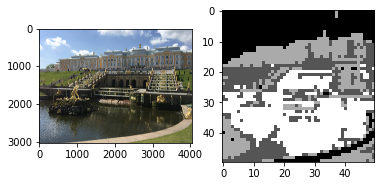

In [13]:
steps = 50
im = np.array(Image.open(os.path.join('images_input', 'Peterhof.jpg')))

dx = int(im.shape[0] / steps)
dy = int(im.shape[1] / steps)

features = []
for x in range(steps):
    for y in range(steps):
        red = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy, 0])
        green = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy, 1])
        blue = np.mean(im[x*dx:(x+1)*dx, y*dy:(y+1)*dy, 2])
        features.append([red, green, blue])
features = np.array(features, 'f')

centroids, variance = kmeans(features, 4)
code, distance = vq(features, centroids)

codeim = code.reshape((steps, steps))
codeim = np.array(Image.fromarray(codeim).resize((steps, steps), resample=Image.Resampling.NEAREST))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(codeim)
plt.show()

# Иерархическая кластеризация

In [14]:
class0 = 1.5 * np.random.randn(100, 2)
class1 = np.random.randn(100, 2) + np.array([5, 5])
features = np.vstack((class0, class1))

tree = hcluster.hcluster(features)

clusters = tree.extract_clusters(5)
print(f'Количество кластеров = {len(clusters)}')

for i, c in enumerate(clusters):
    print(f'Кластер {i+1}: {c.get_cluster_elements()}.')


Количество кластеров = 2
Кластер 1: [147, 158, 106, 138, 111, 141, 160, 185, 175, 121, 128, 119, 129, 123, 126, 140, 150, 195, 173, 187, 168, 133, 186, 135, 161, 114, 136, 139, 127, 197, 182, 198, 193, 180, 184, 115, 137, 122, 146, 151, 178, 143, 164, 107, 112, 120, 188, 153, 157, 118, 104, 169, 145, 100, 199, 179, 148, 172, 181, 130, 113, 117, 152, 171, 196, 167, 176, 170, 183, 156, 165, 116, 124, 166, 109, 125, 162, 155, 174, 102, 101, 105, 163, 142, 134, 189, 154, 192, 191, 159, 131, 149, 103, 144, 132, 194, 190, 177, 108, 110].
Кластер 2: [74, 69, 86, 40, 43, 71, 23, 87, 64, 4, 83, 34, 36, 8, 62, 68, 99, 31, 35, 48, 70, 95, 3, 76, 50, 13, 93, 55, 33, 56, 38, 22, 82, 0, 27, 81, 49, 19, 75, 44, 90, 51, 9, 89, 57, 65, 29, 84, 5, 39, 37, 73, 79, 42, 63, 30, 52, 80, 97, 28, 46, 72, 7, 66, 25, 1, 16, 54, 77, 47, 11, 53, 10, 61, 94, 12, 20, 14, 92, 26, 59, 32, 91, 45, 60, 85, 18, 21, 41, 78, 24, 15, 58, 96, 88, 6, 67, 17, 2, 98].


In [15]:
projected = np.array([np.dot(v[:40], immatrix[i] - immean) for i, _ in enumerate(imlist)])
tree = hcluster.hcluster(projected)
hcluster.draw_dendrogram(
    tree,
    imlist,
    filename=os.path.join('images_output', 'a_fonts_dendrogram_clusters.jpg')
)

# Спектральная кластеризация

Кластер №1


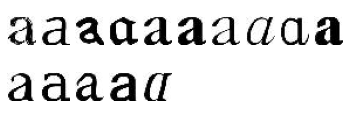

Кластер №2


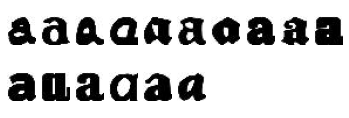

Кластер №3


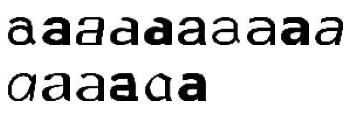

Кластер №4


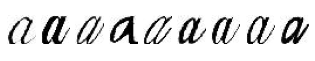

Кластер №5


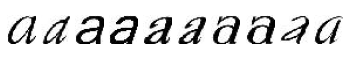

In [16]:
n = len(projected)

s = np.array([[np.sqrt(np.sum((projected[i] - projected[j])**2)) for i in range(n)] for j in range(n)], 'f')

rowsum = np.sum(s, axis=0)
d = np.diag(1 / np.sqrt(rowsum))
i = np.identity(n)
l = i - np.dot(d, np.dot(s, d))

u, sigma, v = np.linalg.svd(l)

k = 5
features = np.array(v[:k]).T
features = whiten(features)
centroids, distortion = kmeans(features, k)
code, distance = vq(features, centroids)

for c in range(k):
    ind = np.where(code == c)[0]
    print(f'Кластер №{c+1}')
    plt.figure()
    for i in range(np.minimum(len(ind), 39)):
        im = Image.open(imlist[ind[i]])
        plt.subplot(4, 10, i+1)
        plt.imshow(np.array(im))
        plt.axis('equal')
        plt.axis('off')
    plt.show()


<!--NAVIGATION-->
<[Глава 5. Многовидовая геометрия](5_multiple_view_geometry.ipynb) | [Содержание](0_index.ipynb) | [Глава 7. Поиск изображений](7_searching_images.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/6_clustering_images.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>